In [1]:
import tensorflow as tf
from keras import layers

2024-03-24 22:08:28.924603: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-24 22:08:29.379263: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2024-03-24 22:08:31.399385: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12, 12, 17)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 12, 12, 64)   9856        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 12, 12, 64)   36928       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 12, 12, 64)   36928       ['conv2d_1[0][0]']           

2024-03-24 22:08:31.417749: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-24 22:08:31.417795: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-24 22:08:31.420325: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-24 22:08:31.420367: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-24 22:08:31.420397: I tensorflow/compile

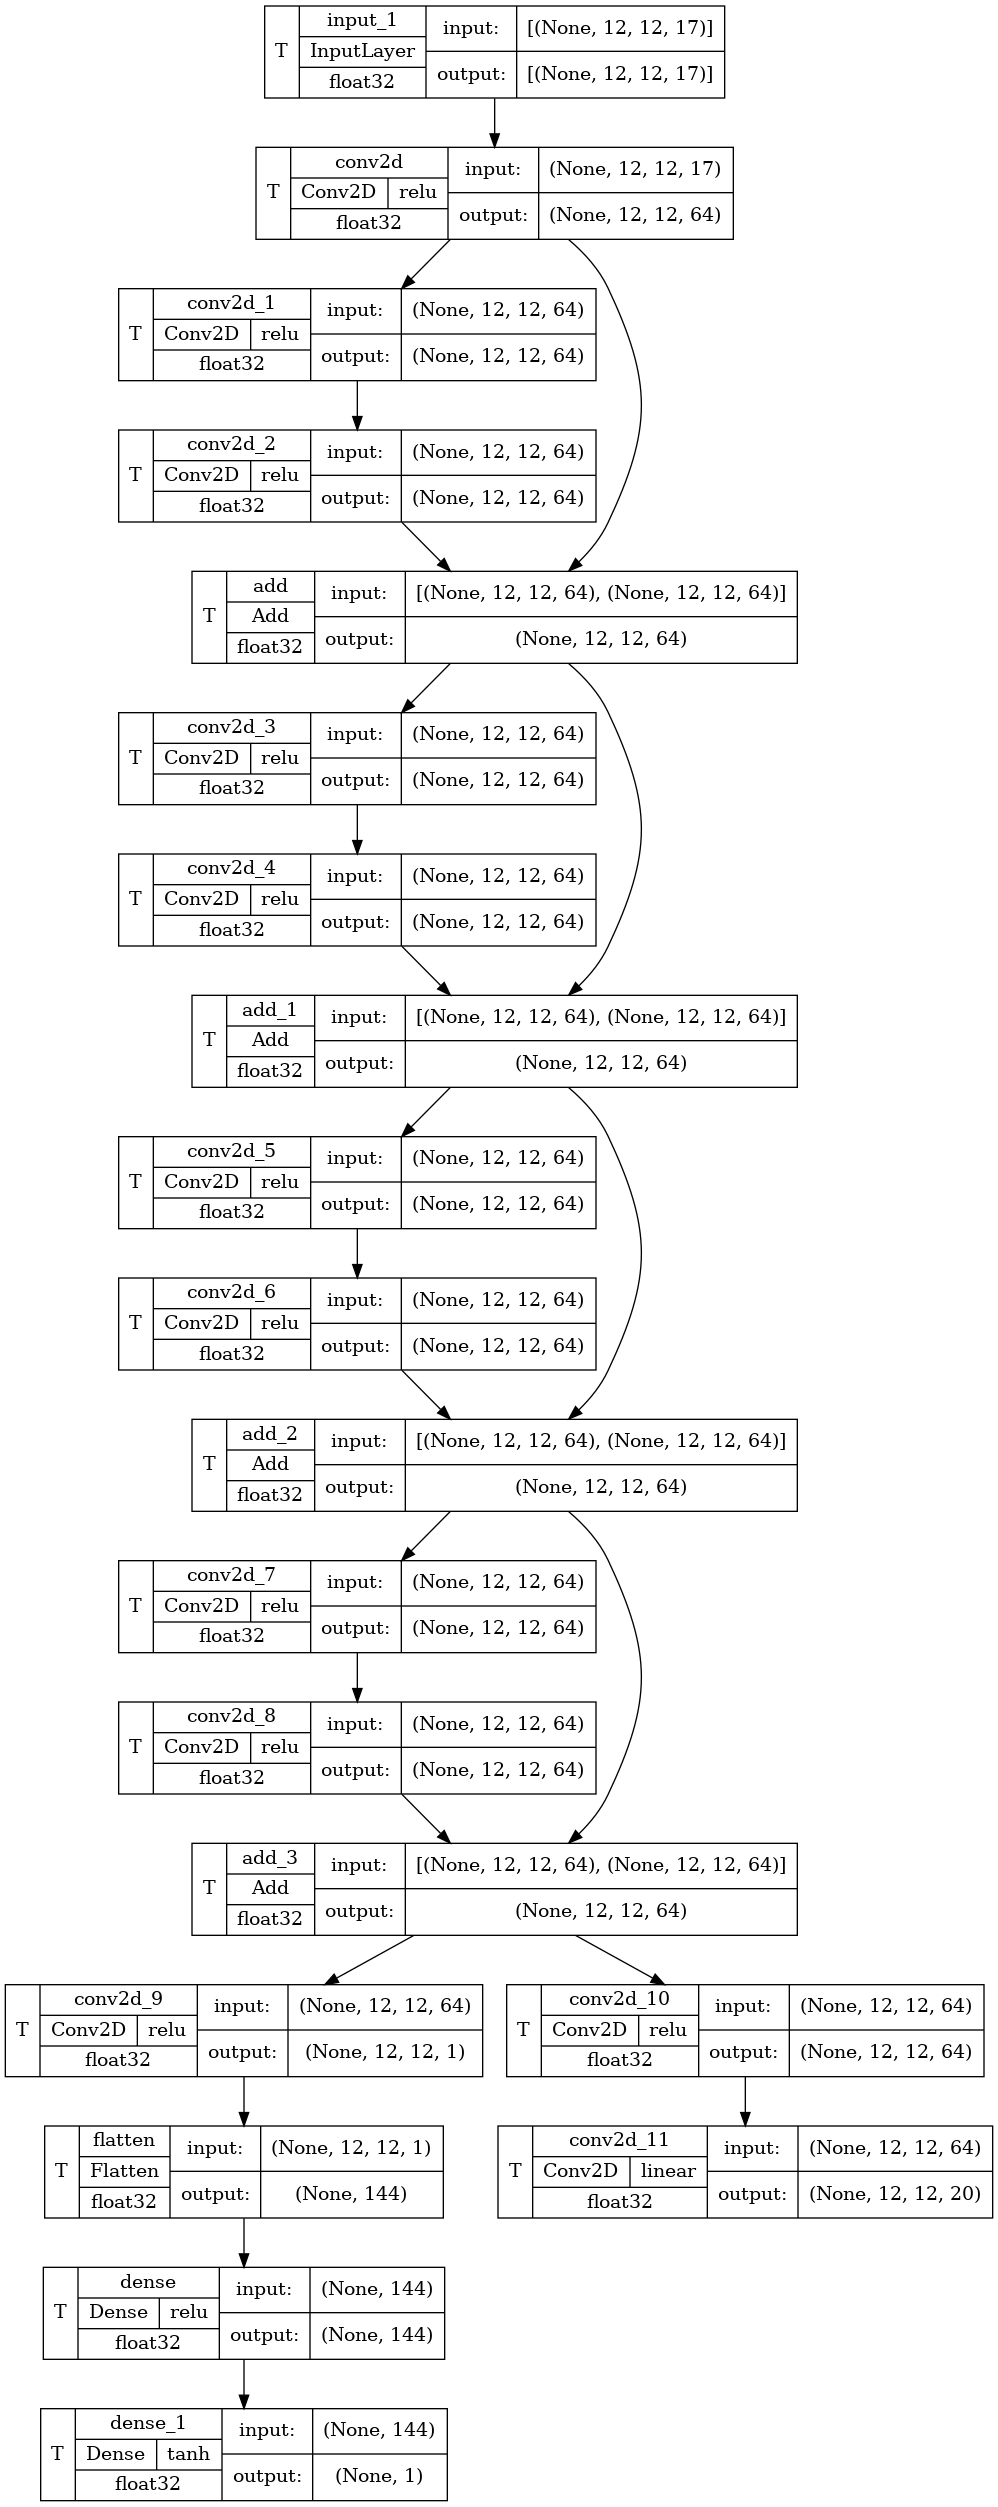

In [2]:
# INPUT_SPEC
BOARD_SIZE = 12
ACTIONS = 20
ELEMENT_CLASSES = 3  # FACTION_1, FACTION_2, NEUTRAL (ELEMENT)
IS_CONTROLLED = 1
ATTRIBUTES = 4
STATUES = 9  # should be an encoded process set?

# MODEL SPEC
CONV_FILTERS = 64
KERNEL = 3
NUM_RES_BLOCKS = 4


# TODO add batch norm.

def res_block(y):
    j = layers.Conv2D(filters=CONV_FILTERS, kernel_size=KERNEL, strides=1, padding='same', activation='relu' )(y)
    j = layers.Conv2D(filters=CONV_FILTERS, kernel_size=KERNEL, strides=1, padding='same', activation='relu' )(j)
    return layers.Add()([j, y])


def build_model():
    input_layer = layers.Input(shape=(BOARD_SIZE, BOARD_SIZE, ELEMENT_CLASSES + IS_CONTROLLED + ATTRIBUTES + STATUES))

    x = layers.Conv2D(filters=CONV_FILTERS, kernel_size=KERNEL, strides=1, padding='same', activation='relu')(
        input_layer)

    for _ in range(NUM_RES_BLOCKS):  # todo dont use for loop
        x = res_block(x)

    # policy head
    px = layers.Conv2D(filters=1, kernel_size=1,  padding='same', activation='relu')(x)
    px = layers.Flatten()(px)
    px = layers.Dense(BOARD_SIZE * BOARD_SIZE, activation='relu')(px)
    policy_output_layer = layers.Dense(1, activation='tanh')(px)

    # value head
    vx = layers.Conv2D(filters=CONV_FILTERS, kernel_size=1, padding='same', activation='relu')(x)
    vx = layers.Conv2D(filters=ACTIONS, kernel_size=1, padding='same')(vx)
    # TODO mask them
    value_output_layer = vx

    return tf.keras.models.Model(inputs=input_layer, outputs=[policy_output_layer, value_output_layer])
    # return tf.keras.models.Model(inputs=input_layer, outputs=x)


model = build_model()
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer='adam', metrics=['accuracy'])
model.summary()

tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=True
)
